<a href="https://colab.research.google.com/github/yuvalmay30/waldo-finder/blob/main/Waldo_Finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Clone repo, install dependencies and check PyTorch and GPU.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.1-221-gd07f9ce Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (4 CPUs, 25.5 GB RAM, 42.2/166.8 GB disk)


In [5]:
# %cd yolov5
import utils
from IPython import display
from IPython.display import clear_output
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

import cv2
from google.colab.patches import cv2_imshow


%matplotlib inline

# Data Importing

In [4]:
%rm -r ../datasets
%rm -r ../waldo-finder

rm: cannot remove '../datasets': No such file or directory
rm: cannot remove '../waldo-finder': No such file or directory


In [5]:
%cd ..
!git clone https://github.com/yuvalmay30/waldo-finder.git  # clone
%cd yolov5/

/content
Cloning into 'waldo-finder'...
remote: Enumerating objects: 8152, done.
remote: Counting objects: 100% (1731/1731), done.
remote: Compressing objects: 100% (1608/1608), done.
remote: Total 8152 (delta 9), reused 1729 (delta 7), pack-reused 6421
Receiving objects: 100% (8152/8152), 1.25 GiB | 17.45 MiB/s, done.
Resolving deltas: 100% (225/225), done.
Checking out files: 100% (5494/5494), done.
/content/yolov5


In [6]:
%cp -R ../waldo-finder/datasets ../datasets

In [7]:
import shutil

def copy_dataset_yaml_to_yolo_data_directory(dataset_dir_name):
  source_file = f'../datasets/{dataset_dir_name}/{dataset_dir_name}.yaml'
  destination_file = f'./data/{dataset_dir_name}.yaml'
  
  shutil.copy(source_file, destination_file)


copy_dataset_yaml_to_yolo_data_directory('source_dataset_v2')
copy_dataset_yaml_to_yolo_data_directory('source_dataset_v2_cropped_val')
copy_dataset_yaml_to_yolo_data_directory('source_dataset_v2_tiled_5_4')
copy_dataset_yaml_to_yolo_data_directory('source_dataset_v2_train_val_tiled_640')

In [8]:
%cp -R /content/drive/MyDrive/CV\ Projects/Waldo\ Finder/best_non_freezed_with_augmetantions_and_tile_size_640.pt  ./models
%cp -R /content/drive/MyDrive/CV\ Projects/Waldo\ Finder/best_freezed_with_augmetantions_and_tile_size_640.pt  ./models

## Examination of basic yolov5x

detect: weights=['yolov5x.pt'], source=../datasets/source_dataset_v2_train_val_tiled_640/train/images/waldo_11_jpg.rf.c843db276c72fa8b57483200ee3c54ce_0_2.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.01, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-207-g5774a15 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
image 1/1 /content/datasets/source_dataset_v2_train_val_tiled_640/train/images/waldo_11_jpg.rf.c843db276c72fa8b57483200ee3c54ce_0_2.jpg: 640x640 3 persons, 1 horse, 5 vases, 1 teddy bear, Done. (0.089s)
Speed: 0.7ms pre-process, 88.6ms inference, 1.4ms NMS per image at shape (1, 3, 640, 64

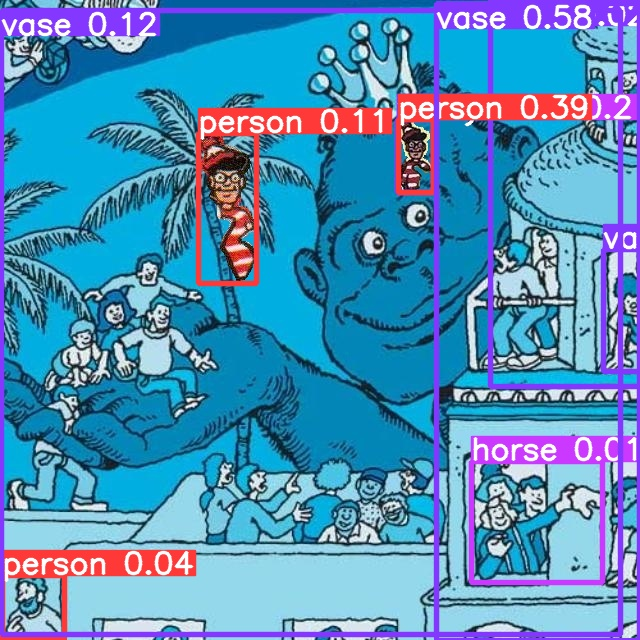

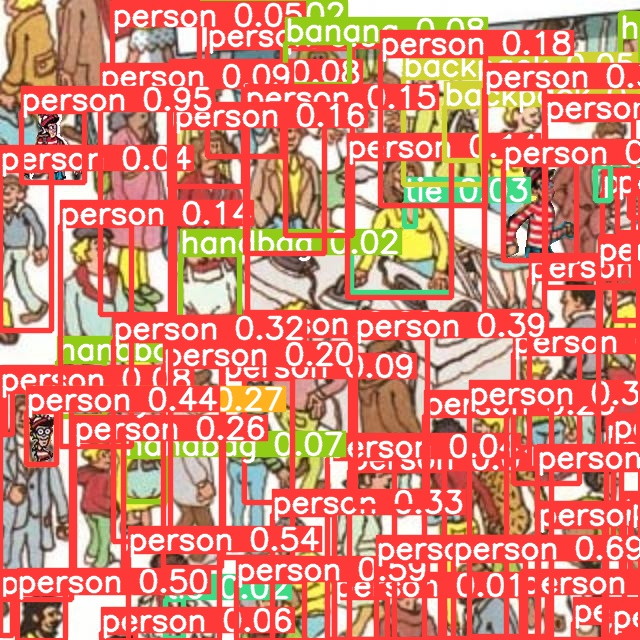

In [14]:
!python detect.py --weights yolov5x.pt --source ../datasets/source_dataset_v2_train_val_tiled_640/train/images/waldo_11_jpg.rf.c843db276c72fa8b57483200ee3c54ce_0_2.jpg --conf-thres 0.01 --iou 0.45 --img 640
!python detect.py --weights yolov5x.pt --source ../datasets/source_dataset_v2_train_val_tiled_640/train/images/waldo_13_jpg.rf.bc8cb6aaf010ee1dd4f1b8af5de907ae_1_0.jpg --conf-thres 0.01 --iou 0.45 --img 640
img1 = cv2.imread('./runs/detect/exp/waldo_11_jpg.rf.c843db276c72fa8b57483200ee3c54ce_0_2.jpg')
img2 = cv2.imread('./runs/detect/exp2/waldo_13_jpg.rf.bc8cb6aaf010ee1dd4f1b8af5de907ae_1_0.jpg')
cv2_imshow(img1)
cv2_imshow(img2)

## Weights & Biases

In [8]:
%pip install -q wandb
import wandb
wandb.login()

     |████████████████████████████████| 1.8 MB 12.3 MB/s 
     |████████████████████████████████| 145 kB 92.4 MB/s 
     |████████████████████████████████| 181 kB 947 kB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Training

In [67]:
# !python train.py --batch 46 --epochs 400 --data source_dataset_v2_tiled_5_4.yaml --weights ./runs/train/exp2/weights/last.pt --cache --freeze 10
# !python train.py --batch 46 --epochs 400 --data source_dataset_v2_tiled_5_4.yaml --weights ./models/last_yolov5x_200epochs_freeze.pt --cache --freeze 10
# !python train.py --batch 32 --epochs 300 --data source_dataset_v2_tiled_5_4.yaml --weights ./models/best_model_with_augmentations.pt --cache --freeze 10
# !python train.py --batch 46 --epochs 80 --data source_dataset_v2_train_val_tiled_640.yaml --weights yolov5x.pt --cache --freeze 10
!python train.py --batch 8 --epochs 80 --data source_dataset_v2_train_val_tiled_640.yaml --weights yolov5x.pt --cache
# !python train.py --batch 8 --epochs 70 --data source_dataset_v2_tiled_5_4.yaml --weights ./runs/train/exp/weights/last.pt --cache

wandb: Currently logged in as: yuvalmay30. Use `wandb login --relogin` to force relogin
train: weights=yolov5x.pt, cfg=, data=source_dataset_v2_train_val_tiled_640.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=80, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-207-g5774a15 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.

## Utils functions for predictions

In [17]:
from typing import Tuple
import os
import math
import pdb
import numpy as np
import pandas as pd
from pathlib import Path


def xyxyn2xyxy(xyxyn, width, height):
  xyxy = xyxyn.clone()

  xyxy[:, 0] = xyxyn[:, 0] * width
  xyxy[:, 1] = xyxyn[:, 1] * height
  xyxy[:, 2] = xyxyn[:, 2] * width
  xyxy[:, 3] = xyxyn[:, 3] * height

  return xyxy


def xyxy2xyxyn(xyxy, width, height):
  xyxyn = xyxy.clone()

  xyxyn[:, 0] = xyxy[:, 0] / width
  xyxyn[:, 1] = xyxy[:, 1] / height
  xyxyn[:, 2] = xyxy[:, 2] / width
  xyxyn[:, 3] = xyxy[:, 3] / height

  return xyxyn
  

def xywhn2xyxyn(xywhn):
  xyxyn = xywhn.clone()

  xyxyn[:, 0] = xywhn[:, 0] - xywhn[:, 2] / 2
  xyxyn[:, 1] = xywhn[:, 1] - xywhn[:, 3] / 2
  xyxyn[:, 2] = xywhn[:, 0] + xywhn[:, 2] / 2
  xyxyn[:, 3] = xywhn[:, 1] + xywhn[:, 3] / 2

  return xyxyn


def sort_predictions_by_confidence(predictions: pd.DataFrame):
  return predictions.sort_values(by=['confidence'], ascending=False)


def convert_predictions_bboxes_values_to_int(predictions):
  return predictions.astype({'xmin': 'int', 'ymin': 'int', 'xmax': 'int', 'ymax': 'int'})


def get_top_predictions(predictions, top=5):
  sorted_predictions = sort_predictions_by_confidence(predictions)
  top_predictions = sorted_predictions[:top]

  return top_predictions


def get_normalized_predictions_from_model_results(results, top=None, convert_to_int=True):
  predictions = results.pandas().xyxyn[0]

  predictions = predictions[['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class']]
  predictions = predictions.astype({'class': 'int'})
  # pdb.set_trace()

  if top is not None:
    predictions = get_top_predictions(predictions, top)

  if convert_to_int:
    predictions = convert_predictions_bboxes_values_to_int(predictions)
  
  predictions = torch.tensor(predictions.values)
  # predictions = predictions.to_numpy()
  # predictions = torch.tensor(predictions)

  return predictions


def get_denormalized_predictions_from_model_results(results, top=None, convert_to_int=True):
  predictions = results.pandas().xyxy[0]
  
  predictions = predictions[['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class']]
  predictions = predictions.astype({'class': 'int'})
  
  if top is not None:
    predictions = get_top_predictions(predictions, top)

  if convert_to_int:
    predictions = convert_predictions_bboxes_values_to_int(predictions)

  # predictions = predictions.to_numpy()
  predictions = torch.tensor(predictions.values)
  return predictions


def draw_prediction_bbox(image, top_left_coordinates: Tuple, bottom_right_coordinates: Tuple):
  red_color = (0, 0, 255)
  thickness = 6
  
  cv2.rectangle(image, top_left_coordinates, bottom_right_coordinates, red_color, thickness)
  return image


def draw_text_on_image(image, confidence, location):
  text = f'Waldo {confidence.item():.5f}'
  font = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 0.9
  red_color = (0, 0, 255)
  thickness = 2
  
  cv2.putText(image, text, location, font, font_scale, red_color, thickness)
  return image


def draw_predictions_on_image(image, predictions):
  for prediction in predictions:
    x1, y1, x2, y2, confidence, _ = prediction
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    image = draw_prediction_bbox(image, (x1, y1), (x2, y2))
    image = draw_text_on_image(image, confidence, (x1, y1))
  
  return image


def change_file_suffix_to_txt(filename: str) -> str:
  filename = filename[:-3] + 'txt'
  return filename


def load_labels(labels_dir_path: str, filename: str):
  labels_filename = change_file_suffix_to_txt(filename)
  labels_file_path = Path(labels_dir_path) / labels_filename

  with open(labels_file_path) as labels_file:
    labels_as_strings = labels_file.readlines()
  
  num_of_elements_in_label = 5
  labels = torch.empty((len(labels_as_strings), num_of_elements_in_label))

  for index, label in enumerate(labels_as_strings):
    data = label.split()
    data = [float(element) for element in data]
    data = torch.tensor(data)
    labels[index] = data

  return labels


def load_labels_as_xyxyn(labels_dir_path, labels_file_name):
  labels = load_labels(labels_dir_path, labels_file_name)
  labels_bbox_as_xywhn = labels[:, 1:]

  labels_bbox_as_xyxyn = xywhn2xyxyn(labels_bbox_as_xywhn)
  labels[:, 1:] = labels_bbox_as_xyxyn
  
  return labels


def draw_label_bbox(image, top_left_coordinates: Tuple, bottom_right_coordinates: Tuple):
  green_color = (0, 255, 0)
  thickness = 4
  
  cv2.rectangle(image, top_left_coordinates, bottom_right_coordinates, green_color, thickness)
  return image


def extract_bbox_from_label(label, img_width, img_height): 
  w, h = img_width, img_height

  bbox = label[1:]
  x, y, w, h = bbox * torch.tensor([w, h, w, h])
  x1, x2 = int(x)-int(w/2), int(x)+int(w/2)
  y1, y2 = int(y)-int(h/2), int(y)+int(h/2)

  return x1, y1, x2, y2


def draw_labels_on_image(image, labels):
  h, w = image.shape[:2]

  for label in labels:
    xmin, ymin, xmax, ymax = extract_bbox_from_label(label, w, h)
    image = draw_label_bbox(image, (xmin, ymin), (xmax, ymax))

  return image


def get_image_from_model_results(results):
  img = results.imgs[0]
  img = img[..., ::-1]
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img 

In [7]:
def load_model():
  # model = torch.hub.load('./', 'custom', source='local', path='./models/last_yolov5x_200epochs_freeze.pt', force_reload=True)
  # model = torch.hub.load('./', 'custom', source='local', path='./models/best_model_with_black_and_white.pt', force_reload=True)
  # model = torch.hub.load('./', 'custom', source='local', path='./models/best_model_with_black_and_white_200_epochs.pt', force_reload=True)
  # model = torch.hub.load('./', 'custom', source='local', path='./models/best_model_with_augmentations.pt', force_reload=True)
  # model = torch.hub.load('./', 'custom', source='local', path='./runs/train/exp3/weights/best.pt', force_reload=True)
  # model = torch.hub.load('./', 'custom', source='local', path='./models/best_non_freezed_with_augmetantions_and_tile_size_640.pt', force_reload=True)
  model = torch.hub.load('./', 'custom', source='local', path='./models/best_freezed_with_augmetantions_and_tile_size_640.pt', force_reload=True)

  model.conf = 0.00001
  return model

## Visualization

In [10]:
%rm -r ./runs/visualization/validation
%mkdir runs
%mkdir runs/visualization
%mkdir runs/visualization/validation

%rm -r ./runs/visualization/test
%mkdir runs
%mkdir runs/visualization
%mkdir runs/visualization/test

rm: cannot remove './runs/visualization/validation': No such file or directory
mkdir: cannot create directory ‘runs’: File exists
rm: cannot remove './runs/visualization/test': No such file or directory
mkdir: cannot create directory ‘runs’: File exists
mkdir: cannot create directory ‘runs/visualization’: File exists


In [8]:
def draw_labels_and_top_predictions_for_single_image_from_model_results(results, labels_dir_path, labels_file_name, top):
  top_predictions = get_denormalized_predictions_from_model_results(results, top)

  img = get_image_from_model_results(results)
  img_with_drawn_predictions = draw_predictions_on_image(img, top_predictions)

  labels = load_labels(labels_dir_path, labels_file_name)
  img_with_drawn_predictions_and_labels = draw_labels_on_image(img_with_drawn_predictions, labels)
  
  return img_with_drawn_predictions_and_labels


def draw_labels_and_top_predictions_for_single_image(image: np.ndarray, top_predictions_as_xyxy, labels_dir_path, labels_file_name):
  img_with_drawn_predictions = draw_predictions_on_image(image, top_predictions_as_xyxy)

  labels = load_labels(labels_dir_path, labels_file_name)
  img_with_drawn_predictions_and_labels = draw_labels_on_image(img_with_drawn_predictions, labels)
  
  return img_with_drawn_predictions_and_labels

In [9]:
def draw_labels_and_top_predictions(images_dir_path, labels_dir_path, destination_dir, top=5):
  model = load_model()

  for dir_entry in os.scandir(images_dir_path):
    labels_file_name = dir_entry.name

    results = model(dir_entry.path, size=2048)
    img_with_drawn_predictions_and_labels = draw_labels_and_top_predictions_for_single_image_from_model_results(results, labels_dir_path, labels_file_name, top)
    
    file_path = destination_dir / labels_file_name
    cv2.imwrite(file_path, img_with_drawn_predictions_and_labels)
  
  print(f'Results saved to: {destination_dir}')

In [22]:
images_dir_path = '../datasets/source_dataset_v2_cropped_val/valid/images'
labels_dir_path = '../datasets/source_dataset_v2_cropped_val/valid/labels'

destination_dir = Path('./runs') / 'visualization' / 'validation'

draw_labels_and_top_predictions(images_dir_path, labels_dir_path, destination_dir)

requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-221-gd07f9ce Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 444 layers, 86173414 parameters, 0 gradients, 204.0 GFLOPs
Adding AutoShape... 


Results saved to: runs/visualization/validation


In [ ]:
images_dir_path = '../datasets/source_dataset_v2_cropped_val/test/images'
labels_dir_path = '../datasets/source_dataset_v2_cropped_val/test/labels'

destination_dir = Path('./runs') / 'visualization' / 'test'

draw_labels_and_top_predictions(images_dir_path, labels_dir_path, destination_dir)

requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-174-gc4cb7c6 torch 1.11.0+cu113 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model summary: 444 layers, 86173414 parameters, 0 gradients
Adding AutoShape... 


Results saved to: runs/visualization/test


# Metrics


In [11]:
def save_image_to_error_analysis(results, labels_dir_path, labels_file_name, error_analysis_destination_path, k=5):
  img_with_drawn_predictions_and_labels = draw_labels_and_top_predictions_for_single_image_from_model_results(results, labels_dir_path, labels_file_name, top=k)
  save_file_path = error_analysis_destination_path / labels_file_name
  cv2.imwrite(save_file_path, img_with_drawn_predictions_and_labels)

In [12]:
def calculate_image_size_for_inference(original_height: int, original_width: int) -> int:
  print(original_height, original_width)

  input_size_division_restriced_by_model = 32
  average_width_and_height = (original_width + original_height) / 2

  image_size_for_inference = (average_width_and_height // input_size_division_restriced_by_model) * input_size_division_restriced_by_model

  return int(image_size_for_inference)


def wrap_img_to_be_with_rectangle_shape(img: np.ndarray):
  height, width, channels = img.shape
  max_size = max(height, width)
  wrapped_img = np.zeros((max_size, max_size, channels))

  wrapped_img[:height, :width, :] = img
  return wrapped_img


In [20]:
%load ../yolov5/val.py
from val import process_batch


def hit_rate_at_k_with_rectangular_padding(images_dir_path, labels_dir_path, error_analysis_destination_path, k=5):
  hits = np.array([])
  iou_threshold = torch.tensor([0.1])
  
  model = load_model()

  for dir_entry in os.scandir(images_dir_path):
    image_path = dir_entry.path
    image = cv2.imread(image_path)

    image = image[..., ::-1]
    wrapped_img = wrap_img_to_be_with_rectangle_shape(image)

    height, width = image.shape[:2]

    results = model(wrapped_img, size=wrapped_img.shape[0])

    top_predictions = get_denormalized_predictions_from_model_results(results, top=k, convert_to_int=False)
    top_predictions_as_xyxyn_in_original_image = top_predictions.clone()
    top_predictions_as_xyxyn_in_original_image[:, :4] = xyxy2xyxyn(top_predictions[:, :4], width, height)
    # pdb.set_trace()

    labels_file_name = dir_entry.name
    labels = load_labels_as_xyxyn(labels_dir_path, labels_file_name)

    true_positives = process_batch(top_predictions_as_xyxyn_in_original_image, labels, iou_threshold)

    is_hit = torch.any(true_positives)
    hits = np.append(hits, is_hit)

    if not is_hit:
      top_predictions_as_xyxy_in_original_image = top_predictions_as_xyxyn_in_original_image.clone()
      top_predictions_as_xyxy_in_original_image[:, :4] = xyxyn2xyxy(top_predictions_as_xyxyn_in_original_image[:, :4], width, height)
      image = image[..., ::-1]
      img_with_drawn_predictions_and_labels = draw_labels_and_top_predictions_for_single_image(image, top_predictions_as_xyxy_in_original_image, labels_dir_path, labels_file_name)
      
      save_file_path = error_analysis_destination_path / labels_file_name
      cv2.imwrite(save_file_path, img_with_drawn_predictions_and_labels)

  hit_rate = hits.mean()
  print(f'The hit-rate is: {hit_rate}')
  return hit_rate


def hit_rate_at_k(images_dir_path, labels_dir_path, error_analysis_destination_path, k=5):
  hits = np.array([])
  iou_threshold = torch.tensor([0.1])
  
  model = load_model()

  for dir_entry in os.scandir(images_dir_path):
    image_path = dir_entry.path
    image = cv2.imread(image_path)
    image = image[..., ::-1]

    results = model(image, size=2400)

    top_predictions = get_normalized_predictions_from_model_results(results, top=k, convert_to_int=False)
    
    labels_file_name = dir_entry.name
    labels = load_labels_as_xyxyn(labels_dir_path, labels_file_name)

    true_positives = process_batch(top_predictions, labels, iou_threshold)

    is_hit = torch.any(true_positives)
    hits = np.append(hits, is_hit)

    if not is_hit:
      save_image_to_error_analysis(results, labels_dir_path, labels_file_name, error_analysis_destination_path)

  hit_rate = hits.mean()
  print(f'The hit-rate is: {hit_rate}')
  return hit_rate

### Hit-Rate@k (with resize of 2400)

In [24]:
%rm -r ./runs/validation/error_analysis/
%mkdir runs
%mkdir runs/validation
%mkdir runs/validation/error_analysis

images_dir_path = '../datasets/source_dataset_v2_cropped_val/valid/images'
labels_dir_path = '../datasets/source_dataset_v2_cropped_val/valid/labels'

error_analysis_destination_path = Path('./runs') / 'validation' / 'error_analysis'

# hit_rate_at_k_with_rectangular_padding(images_dir_path, labels_dir_path, error_analysis_destination_path, k=5)  
hit_rate_at_k(images_dir_path, labels_dir_path, error_analysis_destination_path, k=5)

mkdir: cannot create directory ‘runs’: File exists
mkdir: cannot create directory ‘runs/validation’: File exists


YOLOv5 🚀 v6.1-221-gd07f9ce Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 444 layers, 86173414 parameters, 0 gradients, 204.0 GFLOPs
Adding AutoShape... 


The hit-rate is: 0.85


0.85

### Hit-Rate@k with recatangular padding

In [25]:
%rm -r ./runs/validation/error_analysis/
%mkdir runs
%mkdir runs/validation
%mkdir runs/validation/error_analysis

images_dir_path = '../datasets/source_dataset_v2_cropped_val/valid/images'
labels_dir_path = '../datasets/source_dataset_v2_cropped_val/valid/labels'

error_analysis_destination_path = Path('./runs') / 'validation' / 'error_analysis'

hit_rate_at_k_with_rectangular_padding(images_dir_path, labels_dir_path, error_analysis_destination_path, k=5)

mkdir: cannot create directory ‘runs’: File exists
mkdir: cannot create directory ‘runs/validation’: File exists


YOLOv5 🚀 v6.1-221-gd07f9ce Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 444 layers, 86173414 parameters, 0 gradients, 204.0 GFLOPs
Adding AutoShape... 


The hit-rate is: 0.85


0.85

In [26]:
import torchvision
from math import ceil


def split_image_to_tiles(image: np.ndarray, tile_size: int) -> np.ndarray:
  height, width = image.shape[:2]
  tiles = [image[x: x+tile_size, y:y+tile_size] for x in range(0, height, tile_size) for y in range(0, width, tile_size)]

  tiles = np.array(tiles)
  
  num_of_horizontal_tiles = ceil(width / tile_size)
  num_of_vertical_tiles = ceil(height / tile_size)

  tiles = tiles.reshape((num_of_vertical_tiles, num_of_horizontal_tiles))

  return tiles


def detect_on_tiled_image_and_get_top_predictions(model, image_path: str, k: int, tile_size: int = 640):
  image = cv2.imread(image_path)
  image = image[..., ::-1]

  tiles = split_image_to_tiles(image, tile_size)

  image_height, image_width = image.shape[:2]
  all_predictions = torch.tensor([])
  for i, row in enumerate(tiles):
    for j, tile in enumerate(row):
      results = model(tile, size=tile_size)
      tile_predictions_as_xyxy = get_denormalized_predictions_from_model_results(results, convert_to_int=False)

      tile_xmin_scaled_to_original_image = j * tile_size
      tile_ymin_scaled_to_original_image = i * tile_size

      tile_predictions_scaled_to_original_image_as_xyxy = tile_predictions_as_xyxy.clone()
      tile_predictions_scaled_to_original_image_as_xyxy[:, 0] = tile_xmin_scaled_to_original_image + tile_predictions_scaled_to_original_image_as_xyxy[:, 0]
      tile_predictions_scaled_to_original_image_as_xyxy[:, 1] = tile_ymin_scaled_to_original_image + tile_predictions_scaled_to_original_image_as_xyxy[:, 1]
      tile_predictions_scaled_to_original_image_as_xyxy[:, 2] = tile_xmin_scaled_to_original_image + tile_predictions_scaled_to_original_image_as_xyxy[:, 2]
      tile_predictions_scaled_to_original_image_as_xyxy[:, 3] = tile_ymin_scaled_to_original_image + tile_predictions_scaled_to_original_image_as_xyxy[:, 3]

      tile_predictions_bboxes_scaled_to_original_image_as_xyxy = tile_predictions_scaled_to_original_image_as_xyxy[:, :4]
      tile_predictions_bboxes_scaled_to_original_image_as_xyxyn = xyxy2xyxyn(tile_predictions_bboxes_scaled_to_original_image_as_xyxy, image_width, image_height)

      tile_predictions_scaled_to_original_image_as_xyxyn = tile_predictions_scaled_to_original_image_as_xyxy.clone()
      tile_predictions_scaled_to_original_image_as_xyxyn[:, :4] = tile_predictions_bboxes_scaled_to_original_image_as_xyxyn

      all_predictions = torch.cat((all_predictions, tile_predictions_scaled_to_original_image_as_xyxyn))

  nms_iou_thres = 0.1
  nms_indices = torchvision.ops.nms(all_predictions[:, :4], all_predictions[:, 4], nms_iou_thres)  # NMS
  all_predictions = all_predictions[nms_indices]

  sorted_predictions = all_predictions[all_predictions[:, 4].sort(descending=True)[1]]
  top_predictions = sorted_predictions[:k]

  return top_predictions

In [27]:
from val import process_batch


def hit_rate_at_k_with_tiling(images_dir_path, labels_dir_path, error_analysis_destination_path, k=5):
  hits = np.array([])
  iou_threshold = torch.tensor([0.1])
  
  model = load_model()

  for dir_entry in os.scandir(images_dir_path):
    image_path = dir_entry.path
  
    top_predictions = detect_on_tiled_image_and_get_top_predictions(model, image_path, k, tile_size=640)

    labels_file_name = dir_entry.name
    labels = load_labels_as_xyxyn(labels_dir_path, labels_file_name)

    true_positives = process_batch(top_predictions, labels, iou_threshold)

    is_hit = torch.any(true_positives)
    hits = np.append(hits, is_hit)

    if not is_hit:
      image = cv2.imread(image_path)
      image_height, image_width = image.shape[:2]

      top_predictions_bboxes_as_xyxy = xyxyn2xyxy(top_predictions[:, :4], image_width, image_height)
      top_predictions_as_xyxy = top_predictions.clone()
      top_predictions_as_xyxy[:, :4] = top_predictions_bboxes_as_xyxy

      img_with_drawn_predictions_and_labels = draw_labels_and_top_predictions_for_single_image(image, top_predictions_as_xyxy, labels_dir_path, labels_file_name)
      
      save_file_path = error_analysis_destination_path / labels_file_name
      cv2.imwrite(save_file_path, img_with_drawn_predictions_and_labels)

  hit_rate = hits.mean()
  print(f'The hit-rate is: {hit_rate}')
  return hit_rate

### Hit-Rate@k with tiling


In [28]:
%rm -r ./runs/validation/error_analysis/
%mkdir runs
%mkdir runs/validation
%mkdir runs/validation/error_analysis

images_dir_path = '../datasets/source_dataset_v2_cropped_val/valid/images'
labels_dir_path = '../datasets/source_dataset_v2_cropped_val/valid/labels'

error_analysis_destination_path = Path('./runs') / 'validation' / 'error_analysis'

hit_rate_at_k_with_tiling(images_dir_path, labels_dir_path, error_analysis_destination_path, k=5)  

mkdir: cannot create directory ‘runs’: File exists
mkdir: cannot create directory ‘runs/validation’: File exists


YOLOv5 🚀 v6.1-221-gd07f9ce Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 444 layers, 86173414 parameters, 0 gradients, 204.0 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecati

The hit-rate is: 0.85


0.85

In [28]:
%rm -r ./runs/test/error_analysis/
%mkdir runs
%mkdir runs/test
%mkdir runs/test/error_analysis

test_images_dir_path = '../datasets/source_dataset_v2_cropped_val/test/images'
test_labels_dir_path = '../datasets/source_dataset_v2_cropped_val/test/labels'

error_analysis_destination_path = Path('./runs') / 'test' / 'error_analysis'

hit_rate_at_k_with_tiling(test_images_dir_path, test_labels_dir_path, error_analysis_destination_path, k=5)  

mkdir: cannot create directory ‘runs’: File exists
mkdir: cannot create directory ‘runs/test’: File exists


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-221-gd07f9ce Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 444 layers, 86173414 parameters, 0 gradients, 204.0 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged neste

The hit-rate is: 0.75


0.75

requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-214-g541a5b7 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 444 layers, 86173414 parameters, 0 gradients, 204.0 GFLOPs
Adding AutoShape... 


tensor([[2.40425e+00, 2.47604e+02, 3.85062e+01, 3.69104e+02, 2.33692e-01, 0.00000e+00],
        [0.00000e+00, 4.03104e+02, 1.79918e+02, 6.40000e+02, 9.98807e-02, 0.00000e+00]], dtype=torch.float64)


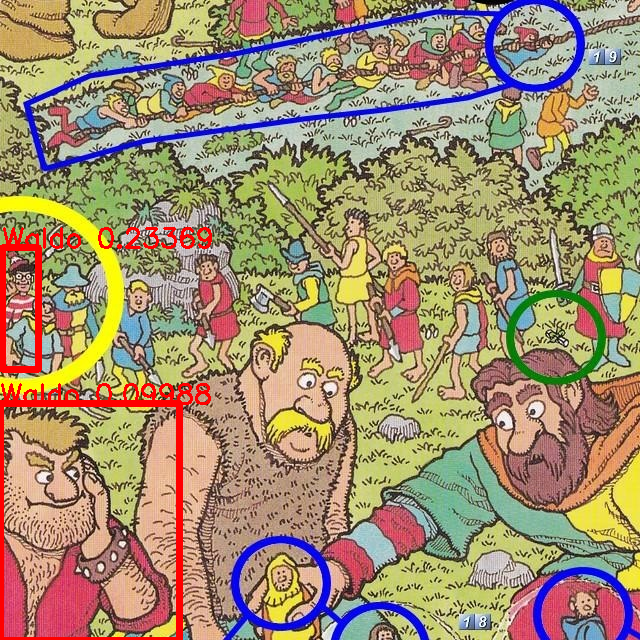

In [87]:
model = load_model()

# image_path = '../datasets/test.png'
# image_path = '../datasets/test2.jng'
# image_path = '../datasets/test3.jpg'
# image_path = '../datasets/test4.jpg'
# image_path = '../datasets/test5.jpg'
image_path = '../datasets/test7.jpg'

image = cv2.imread(image_path)
image = image[..., ::-1]

results = model(image, size=640)

top_predictions = get_denormalized_predictions_from_model_results(results, top=2, convert_to_int=False)
print(top_predictions)

img = get_image_from_model_results(results)
img_with_drawn_predictions = draw_predictions_on_image(img, top_predictions)

cv2_imshow(img_with_drawn_predictions)

### Measure test set metrics


In [29]:
%rm -r ./runs/test/error_analysis/
%mkdir runs
%mkdir runs/test
%mkdir runs/test/error_analysis

test_images_dir_path = '../datasets/source_dataset_v2_cropped_val/test/images'
test_labels_dir_path = '../datasets/source_dataset_v2_cropped_val/test/labels'

error_analysis_destination_path = Path('./runs') / 'test' / 'error_analysis'

hit_rate_at_k_with_rectangular_padding(test_images_dir_path, test_labels_dir_path, error_analysis_destination_path)  

rm: cannot remove './runs/test/error_analysis/': No such file or directory
mkdir: cannot create directory ‘runs’: File exists


YOLOv5 🚀 v6.1-221-gd07f9ce Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 444 layers, 86173414 parameters, 0 gradients, 204.0 GFLOPs
Adding AutoShape... 


The hit-rate is: 0.75


0.75

In [ ]:
# !python val.py --weights models/last_yolov5x_200epochs_freeze.pt --data source_dataset_v2_cropped_val.yaml --half --conf-thres 0.001 --iou 0.1 --img 2048 --single-cls
# !python val.py --weights models/last_yolov5x_200epochs_freeze.pt --data source_dataset_v2.yaml --half --conf-thres 0.01 --img 2048
# !python detect.py --weights ./models/last_yolov5x_200epochs_freeze.pt --source ../datasets/source_dataset_v2_cropped_val/valid/images --conf-thres 0.01 --iou 0.45 --img 2048